In [18]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from src.tags_helpers.tag_grouper import TagGrouper
from src.tags_helpers.graph_plotting import describe_graph, plot_degree_distribution
from src.event_helper.plot_events import read_and_plot_events


# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import the data around COP21

In [19]:
file_name = 'data/climate_videos_v3.jsonl'
df = pd.read_json(file_name, lines=True)
df['upload_date'] = pd.to_datetime(df['upload_date'])
df.set_index('upload_date', inplace=True)
df.sort_index(inplace=True)
df = df.loc[:'2019-07-01'].copy()  #avoid crawl date
cop21_df = df.loc['2015-12-01':'2015-12-31'].copy()

# df = df.iloc[59999:]
df.reset_index(inplace=True)
df.set_index('display_id', inplace=True)
cop21_df.reset_index(inplace=True)
cop21_df.set_index('display_id', inplace=True)

nb_videos = len(df)
nb_cop21_videos = len(cop21_df)

display(df)

,upload_date,categories,channel_id,crawl_date,description,dislike_count,duration,like_count,tags,title,view_count,classification_categories
display_id,,,,,,,,,,,,
rXVcnciIduc,2006-05-23,Howto & Style,UC5MOW8BO3dH38Fo3Rau17KQ,2019-11-02 01:19:20.939142,Water vapour is the primary greenhouse gas.,0.0,61,8.0,"science,climatechange,weather",Professor Tim Palmer on climate change,1644,{'/Science/Ecology & Environment/Climate Chang...
UhVk4R_T7O8,2006-06-07,News & Politics,UCy1UzIJf_Dog0vzLJUPLXHA,2019-11-03 12:38:39.986280,"The DuPont plant in DeLisle, Mississippi has b...",6.0,1713,48.0,"dioxin,duplicity,dupont,sierra,club,chronicles...","Dioxin, Duplicity & Dupont - Sierra Club Chron...",7399,{'/People & Society/Social Issues & Advocacy/G...
RUjM59H3fYk,2006-07-19,News & Politics,UC61qQBrHiNKprDXW5ZnLPyQ,2019-11-03 07:02:08.742306,HotAir.com's Michelle Malkin jumps! to fight g...,104.0,199,192.0,"global,warming,environment,world,jump,day,mich...",VENT Jump!,61816,{'/Science/Ecology & Environment/Climate Chang...
MvTaLdk3-dE,2006-09-07,Howto & Style,UC5MOW8BO3dH38Fo3Rau17KQ,2019-11-02 01:19:20.354547,Hear from the people behind the BBC's global c...,1.0,146,6.0,"science,climate,global,warming,distributed,tem...",What might the climate be in 2053?,1092,{'/Science/Ecology & Environment/Climate Chang...
6otdzD8ncnw,2006-09-22,Music,UCNia_X3a7HLxBSN-z57UGQw,2019-11-04 22:29:01.019235,Musician G. Love and NRDC's Dan Lashof drop rh...,2.0,184,1.0,"nrdc,environment,music,g.love,globalwarming,en...",NRDC at Bonnaroo -- Solve Global Warming!,1033,{'/People & Society/Social Issues & Advocacy/G...
...,...,...,...,...,...,...,...,...,...,...,...,...
aBZOEOBToMc,2019-07-01,News & Politics,UC0xLyicoeOd6KsNbl1Qst1g,2019-11-17 23:55:09.989824,"For the latest news across Belize, visit:\nhtt...",0.0,55,1.0,,Chan Pine Ridge Villager Concern of B.S.I.’s A...,155,{'/People & Society/Social Issues & Advocacy/G...
-PnIwzxZWLY,2019-07-01,News & Politics,UCknLrEdhRCp1aegoMqRaCZg,2019-11-04 04:39:21.234022,Deforestation in the Amazon jungle is destroyi...,3.0,392,117.0,"Peru,rainforest,deforestation,Chaikuni,refores...",Peru: Sustainable farming in the rainforest | ...,3009,{'/People & Society/Social Issues & Advocacy/G...
ES-2e2Tlgy4,2019-07-01,Nonprofits & Activism,UCEwKMXfktjqfaT9JoPB6r-A,2019-11-14 02:29:51.184494,"Celebrate #PlasticFreeJuly with Sahar Mansoor,...",0.0,96,34.0,,Zero Waste Lifestyle with Sahar Mansoor,701,{'/People & Society/Social Issues & Advocacy/G...


# Map tags to a smaller subset

In [20]:
def preprocess_tags(data: pd.DataFrame):
    tag_grouper = TagGrouper()
    # tag_grouper.reset_cache()
    # 
    # # Manually add specific tags
    # tag_grouper.get('news')
    # tag_grouper.get('cop21')
    # tag_grouper.tags_mapping['breaking news'] = 'news'
    # tag_grouper.tags_mapping["2015 united nations climate change conference"] = "cop21"
    
    tqdm.pandas()
    data = data.apply(lambda tags: tags.split(','))
    data = data.progress_apply(lambda tags: [tag for tag in tags if tag != ''])
    data = data[data.progress_apply(lambda tags: len(tags) > 0)]
    data = data.progress_apply(lambda tags: [tag_grouper.get(tag) for tag in tags])
    tag_grouper.save()
    return data

data = preprocess_tags(df['tags'])

100%|██████████| 59156/59156 [00:02<00:00, 29208.41it/s]


# Take a look at the tag counts

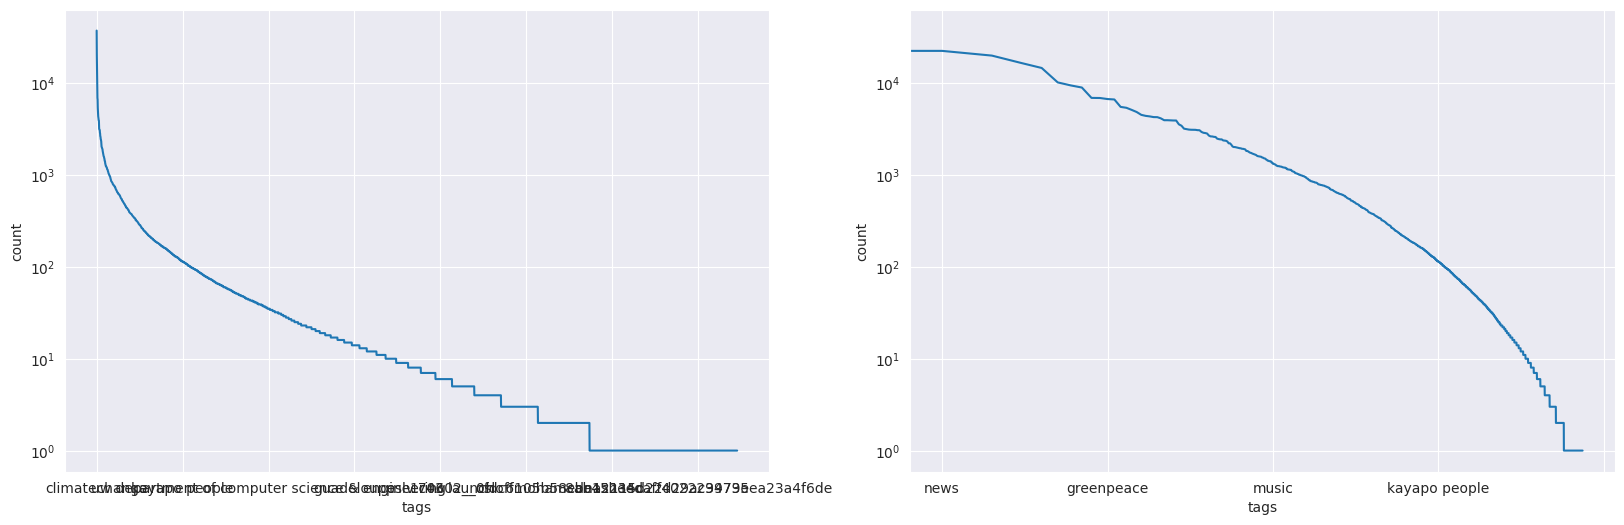

climatechange                                         37356
news                                                  22457
pollution                                             19953
environment                                           16603
warming                                               14629
                                                      ...  
электромобиль                                             1
окружающая среда                                          1
scooptag:100000006101866                                  1
kenya rated position 119 in implementation of sdgs        1
722d0d1d6e53471cc70172f29c1e5d34                          1
Length: 7454, dtype: int64

In [21]:
tags_count = pd.Series(dict(Counter(tag for tags in data for tag in tags)))
tags_count.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True)
tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True)
plt.show()
tags_count

# Only keep the top 90th percentile of tags 

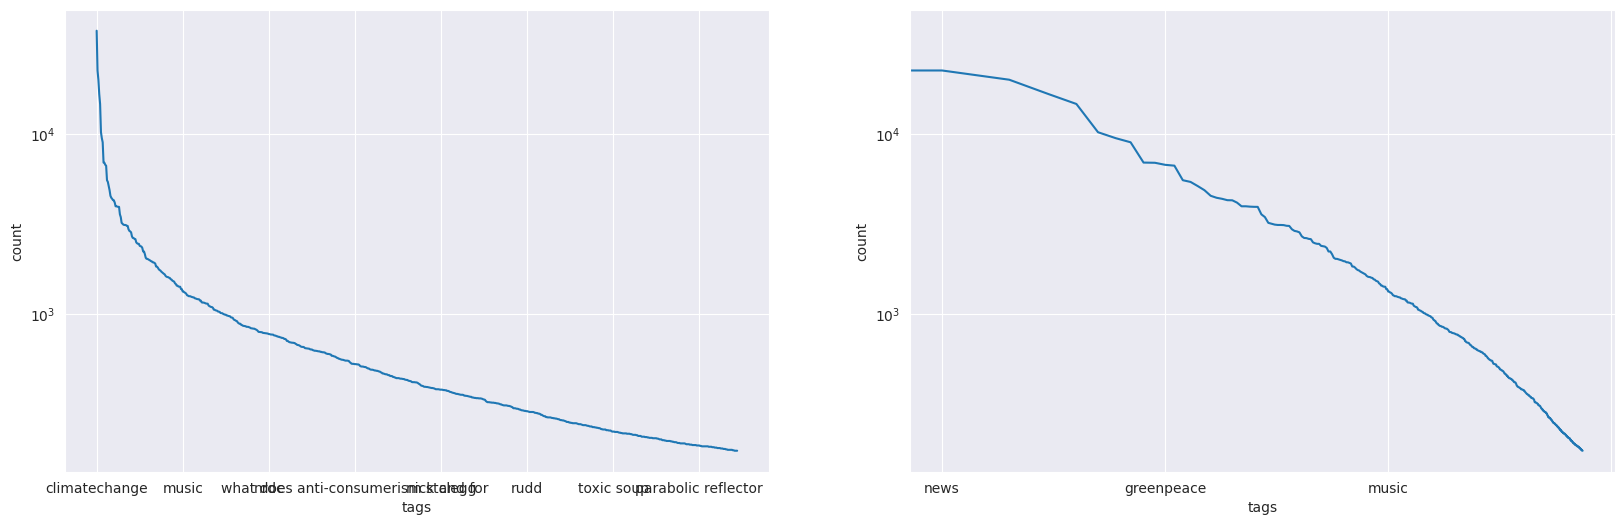

climatechange         37356
news                  22457
pollution             19953
environment           16603
warming               14629
                      ...  
gregory miller          174
reprobate mind          173
lawrence livermore      173
u.s. senate             173
penguin books           173
Length: 745, dtype: int64

In [22]:
threshold = tags_count.quantile(0.9)
common_tags_count = tags_count[tags_count > threshold]
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[0], logy=True, logx=False, grid=True)
common_tags_count.plot(xlabel='tags', ylabel='count', ax=ax[1], logy=True, logx=True, grid=True)
plt.show()
common_tags_count

100%|██████████| 59156/59156 [00:00<00:00, 612332.24it/s]


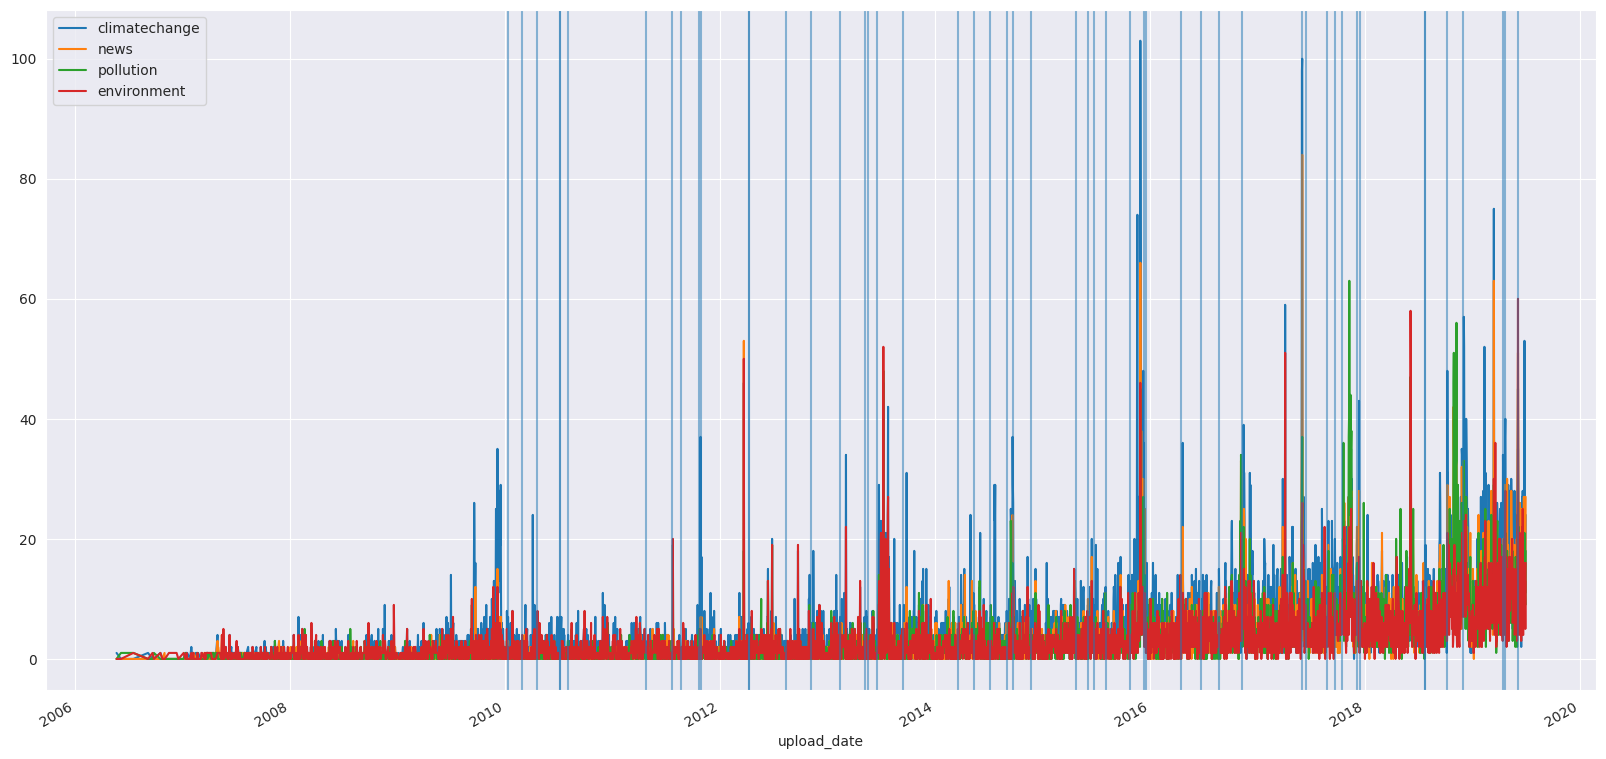

In [38]:
year_data = pd.DataFrame(data)
year_data = year_data.merge(pd.to_datetime(df['upload_date']), left_index=True, right_index=True)

top_tags = list(common_tags_count.index)[:4]
for tag in top_tags:
    year_data[tag] = data.progress_apply(lambda x: int(tag in x))

fig, ax = plt.subplots(figsize=(20, 10))
tags_count_per_date = year_data.groupby('upload_date')[top_tags].sum()
tags_count_per_date.loc[:].plot(ax=ax)
read_and_plot_events(tags_count_per_date, ax)
plt.show()

# Focus on cop21 event

In [35]:
# Keep data of december 2015
cop21_data = cop21_df['tags']
cop21_data = preprocess_tags(cop21_data)

# Only keep the top 90th percentile of tags
cop21_tags_count = pd.Series(dict(Counter(tag for tags in cop21_data for tag in tags)))
cop21_tags_count.sort_values(inplace=True, ascending=False)
threshold = cop21_tags_count.quantile(0.9)
cop21_common_tags_count = cop21_tags_count[cop21_tags_count > threshold]


100%|██████████| 1219/1219 [00:00<00:00, 37646.85it/s]


climatechange          954
news                   657
cop21                  459
pollution              454
warming                385
                      ... 
hot                     34
national geographic     34
health & fitness        34
tucker                  34
broadcasting            34
Length: 100, dtype: int64

# Filter the tags in the dataframe

In [25]:
videos = list(cop21_data.index)
common_tags = set(cop21_common_tags_count.index)
cop21_data = cop21_data.apply(lambda x: [tag for tag in x if tag in common_tags])
cop21_data = cop21_data[cop21_data.progress_apply(lambda tags: len(tags) > 0)]

100%|██████████| 1219/1219 [00:00<00:00, 495143.96it/s]


# Create the bipartite graph between videos and tags

In [26]:
G = nx.Graph()
G.add_nodes_from(common_tags, bipartite=0)
G.add_nodes_from(videos, bipartite=1)

for video, tags in tqdm(cop21_data.items(), total=len(cop21_data)):
    for tag in tags:
        G.add_edge(video, tag)
print(G)

100%|██████████| 1190/1190 [00:00<00:00, 45736.06it/s]

Graph with 1376 nodes and 9810 edges


# Plot a subgraph to visualize the data

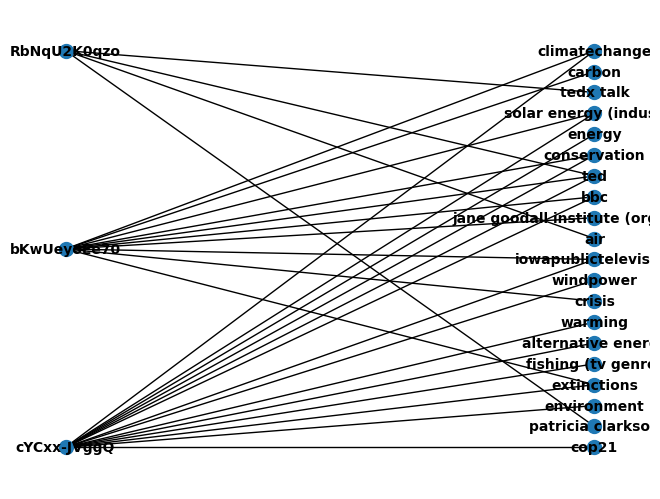

In [27]:
sub_videos = videos[8:11].copy()
sub_tags = []
for node in sub_videos:
    sub_tags.extend(list(G.neighbors(node)))
    
sub_nodes = sub_videos + sub_tags
subgraph = G.subgraph(sub_nodes)
pos = nx.bipartite_layout(subgraph, nodes=sub_videos, scale=1, aspect_ratio=4/3)  # Set the layout for bipartite graphs
nx.draw(subgraph, with_labels=True, pos=pos, node_size=100, font_size=10, font_weight='bold')

# Project the graph onto the tags

In [28]:
print("Start")
tag_graph = nx.bipartite.weighted_projected_graph(G, common_tags, ratio=True)
print(tag_graph)

Start
Graph with 157 nodes and 7879 edges


# Describe the graph

100%|██████████| 157/157 [00:00<00:00, 473404.55it/s]


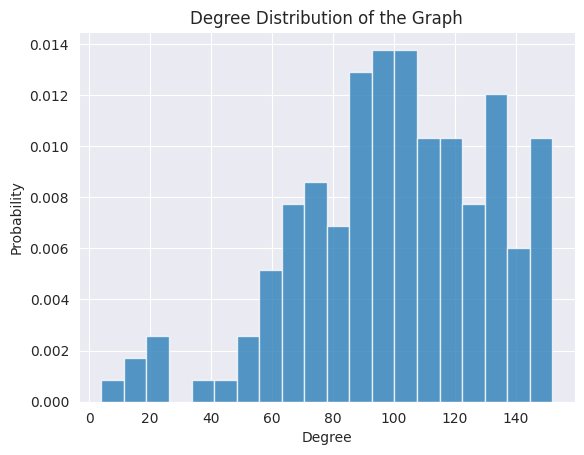

Graph with 157 nodes and 7879 edges
Avg. Shortest Path Length: 1.3569
Diameter: 3.0000
Sparsity: 0.6434
Global clustering coefficient aka Transitivity: 0.7617


In [29]:
# Plot the degree distribution
degree_sequence = [d for n, d in tqdm(tag_graph.degree())]
plt.hist(degree_sequence, bins=20, density=True, alpha=0.75)
plt.title("Degree Distribution of the Graph")
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.show()

# Describe the graph
describe_graph(tag_graph)

In [32]:
edges = tag_graph.edges.data('weight')
threshold = np.percentile([w for _, _, w in edges], 99)
filtered_edges = [(u, v, w) for u, v, w in edges if w > threshold]

filtered_graph = nx.Graph()  
filtered_graph.add_weighted_edges_from(filtered_edges)
print(filtered_graph)

Graph with 27 nodes and 79 edges


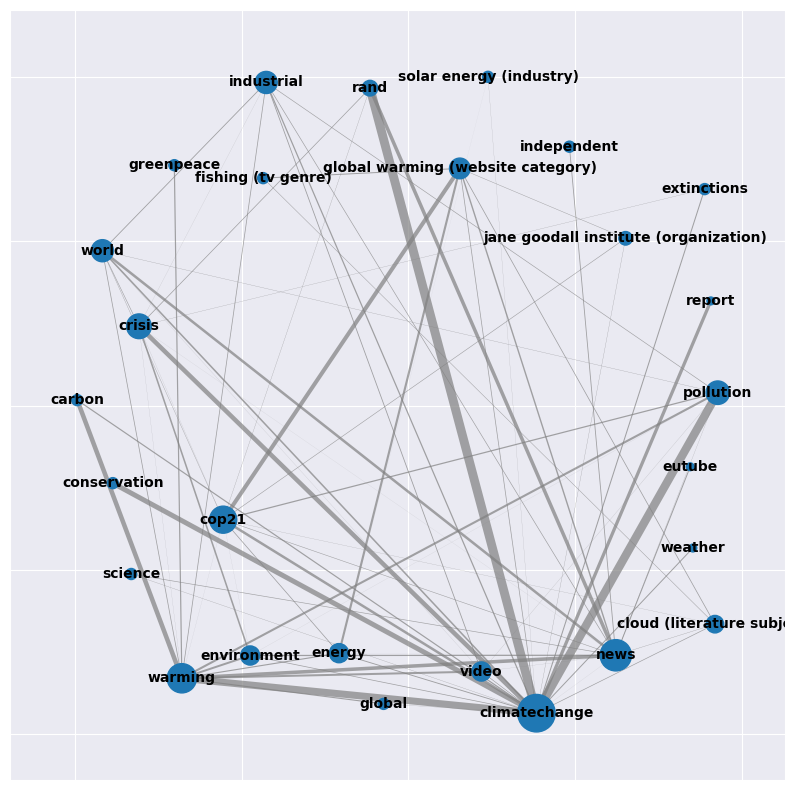

In [36]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(filtered_graph, k=1.1, iterations=20)  # Set the layout for bipartite graphs

weights = np.array([w for _, _, w in filtered_edges])
weights = (weights - weights.min()) / (weights.max() - weights.min() + 0.1) * 10  

degrees = np.array([d for _, d in filtered_graph.degree()]) 
degrees = degrees / (degrees.max() - degrees.min() + 0.1) * 700   # Min max normalize the degrees

nx.draw_networkx_nodes(filtered_graph, pos, node_size=degrees)
nx.draw_networkx_edges(filtered_graph, pos, width=weights, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(filtered_graph, pos, font_size=10, font_weight='bold')
plt.show()